## TripleTen Code Jam 2023
**Team: Santa's Coders**
- Marco Fernstaedt
- Veronica Steele
- Andrew Kwon

In this project, our team designed a delivery route application where users can select a start location and up to seven destinations. This project applies various methods to solving/estimating a small scale adaptation of the traveling salesman problem, or shortest Hamiltonian cycle.

### Libraries, Packages, Modules

The required libraries are contained in the route.py module, and are as follows:
- pandas (2.1.2)
- random
- math
- itertools
- geopy (2.4.1)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from route import Locations, Route
from mpl_toolkits.basemap import Basemap

### Initialization and Preprocessing

The original dataset was dervied from the 2020 US census report. The data descibes the location in latitude-longitude, state, counties, and name for over 20,000 US cities. While the dataset was complete with no missing values, we filtered out cities with populations of less than 400,000 in order to provide users a simplified list of popular destination cities from which to create a route. While the only information used for our route calculations were the city names and their geodetic position, all of the columns were retained with the exception of counties within each city's limit and city type. The resulting dataset has 48 cities with associated state, population, and coordinate location. In this notebook, we'll demonstrate each of the route calculation algorithms by beginning with an arbitrary start city and randomly selecting several destination cities.

In [2]:
df_original = pd.read_csv('datasets/us_cities.csv', encoding='ISO-8859-1')
display(df_original.sample(10))
df_original.info()

,City,State,Type,Counties,Population,Latitude,Longitude
8077,Hull,IA,City,Sioux,2384,43.190,-96.133
1504,Marion,IN,City,Grant,28310,40.559,-85.660
14463,Grosse Tete,LA,Village,Iberville,548,30.415,-91.439
4728,Highland Heights,KY,City,Campbell,6662,39.035,-84.457
15499,Hudson,WY,Town,Fremont,431,42.903,-108.582
12669,Greenleaf,ID,City,Canyon,812,43.673,-116.821
8093,Wellton,AZ,Town,Yuma,2375,32.640,-114.214
8068,Blue Mound,TX,City,Tarrant,2393,32.854,-97.338
20457,Yankee Lake,OH,Village,Trumbull,75,41.268,-80.569
13479,Lake Benton,MN,City,Lincoln,687,44.263,-96.292


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        21397 non-null  object 
 1   State       21397 non-null  object 
 2   Type        21397 non-null  object 
 3   Counties    21397 non-null  object 
 4   Population  21397 non-null  int64  
 5   Latitude    21397 non-null  float64
 6   Longitude   21397 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.1+ MB


We can check for anomalous values such as negative/zero populations and make sure the coordinates appear to be within US territories.

In [3]:
display(df_original[df_original['Population'] <= 0])
display(df_original['Latitude'].agg(['min', 'max']))
display(df_original['Longitude'].agg(['min', 'max']))

,City,State,Type,Counties,Population,Latitude,Longitude
21388,Aldora,GA,Town,Lamar,0,33.049,-84.175
21389,Carbonate,CO,Town,Garfield,0,39.746,-107.340
21390,Cave,MO,Town,Lincoln,0,39.024,-91.042
21391,Goss,MO,Town,Monroe,0,39.515,-91.941
21392,Hoot Owl,OK,Town,Mayes,0,36.360,-95.121
21393,Lakeside,MO,City,Miller,0,38.202,-92.629
21394,Mustang,TX,Town,Navarro,0,32.012,-96.432
21395,South Park View,KY,City,Jefferson,0,38.119,-85.719
21396,Spencer Mountain,NC,Town,Gaston,0,35.309,-81.113


min    19.042
max    71.254
Name: Latitude, dtype: float64

min   -176.566
max    -67.009
Name: Longitude, dtype: float64

There appear to be some cities in the census report that have a population of 0. This will be handled when we filter out cities for our final application (i.e. population >= 400,000). The latitude and longitudinal limits appear correct, with the extremities accounting for Hawaii, Alaska, and some US territories in the Pacific.

### EDA

While not the focus of this notebook or project, we'll conduct cursory EDA to gather interesting data points.

In [4]:
pd.options.display.float_format = '{:.1f}'.format
grp_st = df_original.groupby('State')['Population'].agg(['count', 'mean', 'min', 'max'])
display(grp_st.sort_values(by='count', ascending=False).head(10))

pop_cities = df_original[df_original['Population'] >= 4e5]
grp_pop_cities = pop_cities.groupby('State')['Population'].agg(['count', 'mean', 'min', 'max'])
display(grp_pop_cities.sort_values(by='mean', ascending=False).head(10))

,count,mean,min,max
State,,,,
IL,1298,8605.8,14,2746388
TX,1223,17250.0,0,2304580
PA,1014,5597.5,5,1603797
MO,948,4321.4,0,508090
IA,942,2722.1,4,214133
OH,926,8279.6,28,905748
MN,853,5567.1,10,429954
MI,650,11184.7,104,639111
KS,625,3910.4,8,397532


,count,mean,min,max
State,,,,
NY,1,8804190.0,8804190,8804190
IL,1,2746388.0,2746388,2746388
PA,1,1603797.0,1603797,1603797
TX,6,1267194.8,678815,2304580
CA,9,1061197.4,403455,3898747
OH,1,905748.0,905748,905748
IN,1,887642.0,887642,887642
AZ,3,885008.7,504258,1608139
WA,1,737015.0,737015,737015


The first table shows the top 10 states sorted by city count and their associated aggregate information regarding population. While these states have thousands of cities, the average population is less than 200,000 and even as low as about 3,000. The second table are the cities that will be included in the project. It shows only a few cities within the top ten states meet our criteria with most averages near or over 1 million people! 

The single code line below was used to export the filtered dataset into a separate file in order to eliminate the need for data processing during the live application. As such, it will be commented out for the purpose of this notebook.

In [5]:
#pop_cities = df_original[df_original['Population'] >= 4e5].drop(['Counties', 'Type'], axis=1)
#pop_cities.to_csv('datasets\cities_final.csv', index=False)

### Using the Route Module

The functions used to calcualte the tour costs and CPU runtime for each route are contained in the route.py file, which can be imported to different developement environments for use. The module allows users to create Locations object from the dataset; the Locations object stores the dataset information as a pandas DataFrame and can be retrieved for analysis, as well as to create Route objects for tour calculations. Specific function definitions and documentation can be found within comments of the route.py file.

In [6]:
filepath = 'datasets/cities_final.csv'
cities = Locations(filepath)

df_all_cities = cities.get_all_cities()
display(df_all_cities.sample(10))
df_all_cities.info()

,City,State,Population,Latitude,Longitude
26,Detroit,MI,639111,42.3,-83.0
27,Memphis,TN,633104,35.1,-90.1
28,Louisville,KY,633045,38.3,-85.8
1,Los Angeles,CA,3898747,34.1,-118.2
8,Dallas,TX,1304379,32.8,-96.8
6,San Antonio,TX,1434625,29.4,-98.5
4,Phoenix,AZ,1608139,33.4,-112.1
38,Omaha,NE,486051,41.3,-95.9
36,Mesa,AZ,504258,33.4,-111.8
46,Tulsa,OK,413066,36.2,-96.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        48 non-null     object 
 1   State       48 non-null     object 
 2   Population  48 non-null     int64  
 3   Latitude    48 non-null     float64
 4   Longitude   48 non-null     float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.0+ KB


To demonstrate the route algorithms, we'll pick an arbitrary start city and randomly select nine destination cities.

In [7]:
# 10 cities, then pop the last city to be the originating city
dest_cities = cities.get_all_cities().sample(10, random_state=42)['City'].to_list()
home = dest_cities.pop()
print(f'Home: {home}')
print(f'Cities: {dest_cities}')

Home: Las Vegas
Cities: ['Memphis', 'Raleigh', 'Detroit', 'Miami', 'Portland', 'Atlanta', 'Fort Worth', 'Washington', 'Phoenix']


To facilitate the plotting of each route, we'll retrieve the coordinates for each city from the Locations object. Given the start city and destination nodes, we can generate graph edges, edge weights, and start-arrival coordinates for each city pair. Additionally, we can initialize a Route object to begin calculating various routes and their associated costs.

In [8]:
edges, weights, coords = cities.create_map(home, dest_cities)
route = Route(home, dest_cities, edges, weights)

### Route Algorithms

To illustrate optimization improvements, we'll compare the following search path algorithms:  
- Random path (baseline)
- Greedy
- K-optimal Tours (Heuristic)
- Brute Force

The cost of each tour is the total great circle distance in nautical miles. We'll store the routes and their calculations for comparative analysis in the final portion of this notebook.

In [9]:
algo_names = ['Random', 'Greedy', 'Exact', 'Heuristic']
all_rtes = []
all_dists = []
all_times = []

**Random Route**

As the name implies, the random algorithm selects each destination randomly along the route.

In [10]:
rand_rte, rand_cost, rand_time = route.get_random_rte()

all_rtes.append(rand_rte)
all_dists.append(rand_cost)
all_times.append(rand_time)

print(f'Random Route: {rand_rte}')
print(f'Total Distance: {"{:.1f}".format(rand_cost)} nm')
print(f'Calculation Time: {rand_time} ns')

Random Route: ['Las Vegas', 'Memphis', 'Phoenix', 'Fort Worth', 'Washington', 'Miami', 'Atlanta', 'Raleigh', 'Detroit', 'Portland', 'Las Vegas']
Total Distance: 8556.9 nm
Calculation Time: 0 ns


**Greedy Route**

The greedy algorithm chooses the next closest city for each destination along the route, starting and ending with the home city.

In [11]:
greedy_rte, greedy_cost, greedy_time = route.get_greedy_rte()

all_rtes.append(greedy_rte)
all_dists.append(greedy_cost)
all_times.append(greedy_time)

print(f'Greedy Route: {greedy_rte}')
print(f'Total Distance: {"{:.1f}".format(greedy_cost)} nm')
print(f'Calculation Time: {greedy_time} ns')

Greedy Route: ['Las Vegas', 'Phoenix', 'Fort Worth', 'Memphis', 'Atlanta', 'Raleigh', 'Washington', 'Detroit', 'Miami', 'Portland', 'Las Vegas']
Total Distance: 6511.9 nm
Calculation Time: 0 ns


**Shortest Route**

The shortest route (or exact route) is a brute force approach that tours every Hamiltonian cycle permutation, starting and ending at the home city. The algorithm returns the minimum cost route (i.e. shortest circuit). For a limited amount of destinations, the algorithm is relatively fast, but it is important to note the runtime complexity of this algorithm is FACTORIAL. As such, the performance is severly affected as more cities are added to the route. For example:
- 9 cities = 362,880 permutations
- 10 cities = 3,628,800 permutations
- 13 cities = 6,227,020,800 permutations

In [12]:
exact_rte, exact_cost, exact_time = route.get_exact_rte()

all_rtes.append(exact_rte)
all_dists.append(exact_cost)
all_times.append(exact_time)

print(f'Shortest Route: {exact_rte}')
print(f'Total Distance: {"{:.1f}".format(exact_cost)} nm')
print(f'Calculation Time: {exact_time} ns')

Shortest Route: ['Las Vegas', 'Phoenix', 'Fort Worth', 'Memphis', 'Atlanta', 'Miami', 'Raleigh', 'Washington', 'Detroit', 'Portland', 'Las Vegas']
Total Distance: 5688.1 nm
Calculation Time: 656250000 ns


**Heuristic Route**

The final optimization algorithm incorporates a k-optimal tour (2 edges) heuristic approximation for the shortest path. The starting route that the optimization algorithm attemps to improve is a randomly generated route; it iterates between node pairs and swaps their edges in an attempt to remove overlapping paths along the Hamiltonian cycle. The algorithm stops when the route can no longer be improved (i.e. no longer can lower the local minimum). In this specific approach, we'll be swapping two edges at a time (i.e. 2-opt swapping). This algorithm was chosen because it historically performs well at approximating the shortest Hamiltonian path with relatively fast execution runtime. Specifically, simple euclidean distance variations of this algorithm have been shown to have a runtime complexity of $O(n^{3})$, where $n$ is the number of vertices in the graph.

In [13]:
opt_rte, opt_cost, opt_time = route.get_2opt_rte(rand_rte)

all_rtes.append(opt_rte)
all_dists.append(opt_cost)
all_times.append(opt_time)

print(f'Heuristic Route: {opt_rte}')
print(f'Total Distance: {"{:.1f}".format(opt_cost)} nm')
print(f'Calculation Time: {opt_time} ns')

Heuristic Route: ['Las Vegas', 'Phoenix', 'Fort Worth', 'Memphis', 'Atlanta', 'Miami', 'Raleigh', 'Washington', 'Detroit', 'Portland', 'Las Vegas']
Total Distance: 5688.1 nm
Calculation Time: 0 ns


### Route Visualization and Analysis

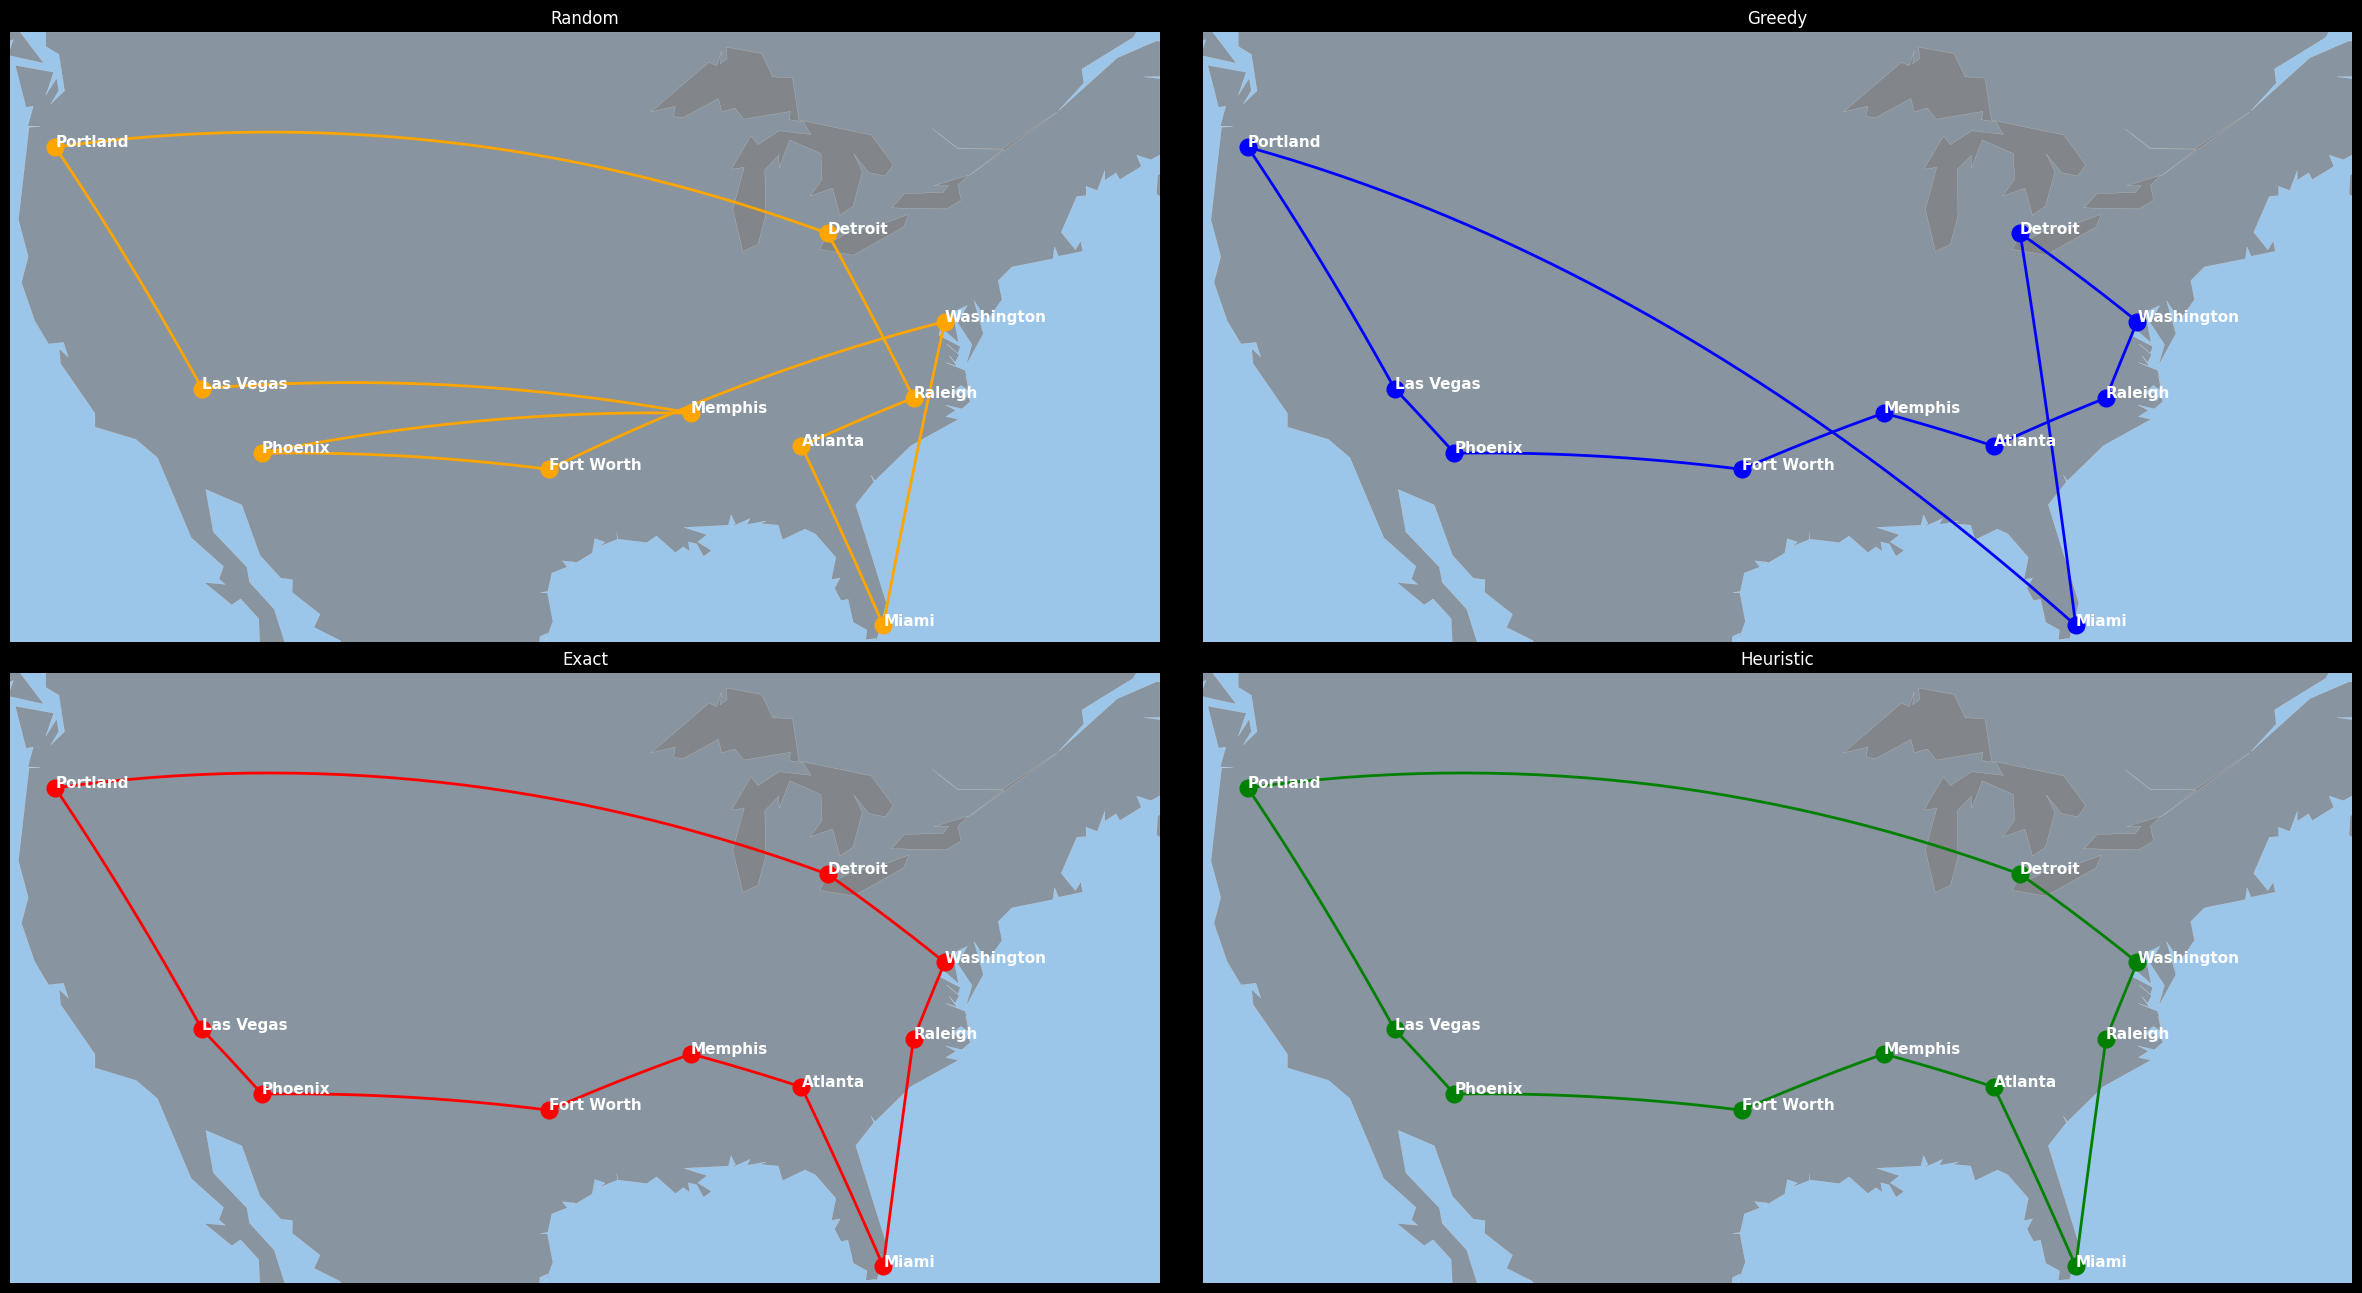

In [14]:
colors = ['orange', 'blue', 'red', 'green']
plt.style.use('dark_background')
fig, axes = plt.subplots(2, 2, figsize=(24, 13))

idx = 0
for i in range(2):
    for j in range(2):
        axes[i][j].set_title(algo_names[idx])
        m=Basemap(llcrnrlon=-125, llcrnrlat=25, urcrnrlon=-66, urcrnrlat=49.5, projection='merc', ax=axes[i][j])
        m.drawmapboundary(fill_color='#9CC5EA', linewidth=0)
        m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
        m.drawcoastlines(linewidth=0.1, color="white")

        rte = all_rtes[idx]
        startlat, startlon = coords[rte[0]]
        for k in range(1, len(rte)):
            arrlat, arrlon = coords[rte[k]]
            x, y = m(arrlon, arrlat)
            axes[i][j].text(x, y, rte[k], fontsize=11, fontweight='bold')
            m.plot(x, y, marker='o', color=colors[idx], markersize=12)
            m.drawgreatcircle(startlon, startlat, arrlon, arrlat, linewidth=2, color=colors[idx], ax=axes[i][j])
            startlat = arrlat
            startlon = arrlon
        idx += 1

fig.tight_layout()
# Remove comment to export plot as .png image
# plt.savefig('route_plot.png')
plt.show()

In [15]:
diff_dist = [(x - exact_cost)/exact_cost for x in all_dists]

index = ['Distance', '% Change', 'Times']
data = [all_dists, diff_dist, all_times]
pd.options.display.float_format = '{:,.2f}'.format
df_results = pd.DataFrame(data = data, index=index, columns=algo_names)

display(df_results)

,Random,Greedy,Exact,Heuristic
Distance,"8,556.87","6,511.94","5,688.09","5,688.09"
% Change,0.50,0.14,0.00,0.00
Times,0.00,0.00,"656,250,000.00",0.00


Barring a lucky guess, it is intuitive that a randomly generated route would have the worst overall performance; that is, it has the worst tour cost associated with its route. The greedy route showed improved performance with a 14% increase in distance from the exact shortest path. The heuristic approach was able to find the shortest path. It is important to note this approximation method DOES NOT guarantee the exact shortest path, and its optimization potential is largely dependent on the initial route. That said, its performance should generally beat other optimization methods such as a greedy search and its runtime is significantly faster than a brute force solution, especially as the number of nodes increase.

When comparing the visuals for each route calculation, human interpretation can intuit the optimal shortest path visually when it comes to cartesian or euclidean distances. Namely, the more times a route's path crosses over itself, the less efficient it is. One way to visualize an optimization approach to graph algorithms similar to these examples is to design a method which "untangles" or minimizes the amount of these cross-overs.

### Sequential Execution Tests

To gather a better idea of optimization accuracy and runtime performance, we'll compare the exact shortest path calculation and the heuristic approach over multiple different routes.

In [16]:
dest_list = []
for i in range(100):
    dest_list.append(cities.get_all_cities().sample(10)['City'].to_list())

Similar to the demonstration above, a random route will be generated for the heuristic algorithm's input (and not count towards its runtime calculation)

In [17]:
exact_dists = []
exact_times = []
opt_dists = []
opt_times = []

for city_list in dest_list:
    start = city_list.pop()
    edges, weights, coords = cities.create_map(start, city_list)
    route = Route(start, city_list, edges, weights)
    
    r, c, t, = route.get_exact_rte()
    exact_dists.append(c)
    exact_times.append(t)

    rand_rte, rand_cost, rand_time = route.get_random_rte()
    r, c, t = route.get_2opt_rte(rand_rte)
    opt_dists.append(c)
    opt_times.append(t)

In [18]:
import math

num_samples = len(dest_list)
min_dist_err = math.inf
max_dist_err = 0.0
min_pcnt_dist_err = math.inf
max_pcnt_dist_err = 0.0
total_dist_error = 0.0
total_time_exact = 0.0
total_time_opt = 0.0
total_pcnt_dist_err = 0.0
count = 0

for i in range(num_samples):
    dist_diff = opt_dists[i] - exact_dists[i]
    if dist_diff == 0:
        count += 1
    pcnt_err = ((opt_dists[i] - exact_dists[i])/exact_dists[i])*100
    if dist_diff < min_dist_err:
        min_dist_err = dist_diff
    if dist_diff > max_dist_err:
        max_dist_err = dist_diff
    if pcnt_err < min_pcnt_dist_err:
        min_pcnt_dist_err = pcnt_err
    if pcnt_err > max_pcnt_dist_err:
        max_pcnt_dist_err = pcnt_err
    
    total_dist_error += dist_diff
    total_time_exact += exact_times[i]
    total_time_opt += opt_times[i]
    total_pcnt_dist_err += pcnt_err

print(f'Heuristic Algorithm Accuracy: {"{:.1f}".format((count/num_samples)*100)}%')
print(f'Minimum Distance Error: {"{:.2f}".format(min_dist_err)} nm, {"{:.2f}".format(min_pcnt_dist_err)}%')
print(f'Maximum Distance Error: {"{:.2f}".format(max_dist_err)} nm, {"{:.2f}".format(max_pcnt_dist_err)}%')
print(f'Average Distance Error: {"{:.2f}".format(total_dist_error/num_samples)} nm, {"{:.2f}".format(total_pcnt_dist_err/num_samples)}%')
print(f'Exact Algorithm Average Runtime (ns): {"{:,.0f}".format(total_time_exact/num_samples)}')
print(f'Optimization Algorithm Average Runtime (ns): {"{:,.0f}".format(total_time_opt/num_samples)}')

Heuristic Algorithm Accuracy: 73.0%
Minimum Distance Error: 0.00 nm, 0.00%
Maximum Distance Error: 189.66 nm, 3.75%
Average Distance Error: 23.34 nm, 0.44%
Exact Algorithm Average Runtime (ns): 618,281,250
Optimization Algorithm Average Runtime (ns): 312,500


While a small sample set (100 iterations), we can glean some interesting results. The hueristic algorithm correctly calculated the shortest path 73% of the time, with a maximum distance error of 189.66 nautical miles (or 3.75%). On average, it's distance error was less than 1%. Additionally, average runtime of the algorithm was three orders of magnitude faster than the exact route algorithm.

*Note: results can vary with subsequent executions of this notebook.*

### Conclusion

This project demonstrated the performance benefits of a heuristic approach to the classic NP-hard problem, the traveling salesman. While there are a few circumstantial requirements in order for the heuristic approach to perform well (i.e. its input/starting route), the benefits in runtime costs may supercede its accuracy when it comes to complex route problems. If complexity or resources are not an issue, however, modern computational power can facilitate an exact solution in acceptable runtimes.